In [1]:
# A pipeline for dating a tree sequence with historical samples in a single step
# by constraining the known times of historical samples using tsdate.core.constrain_ages_topo

# This requires the ancient_samples branch of tsdate, which
# 1. truncates the priors of internal nodes to be at least as old as their oldest descendant sample
# 2. allows fixed nodes to be at a non-zero time
import tsinfer
import msprime
import tskit
import tsdate

import numpy as np
import matplotlib.pyplot as plt

In [2]:
Ne = 10000
samples = [
        msprime.SampleSet(200),
        msprime.SampleSet(1, time=100),
        msprime.SampleSet(1, time=200),   
        msprime.SampleSet(1, time=300),
        msprime.SampleSet(1, time=400),
        msprime.SampleSet(1, time=500),
    ]
mutated_ts = msprime.sim_ancestry(
    samples=samples, population_size=Ne, sequence_length=2e6, recombination_rate=1e-8, random_seed=1)
mutated_ts = msprime.mutate(mutated_ts, rate=1e-8, random_seed=1)


In [3]:
def create_sampledata_with_individual_times(ts):
    """
    The tsinfer.SampleData.from_tree_sequence function doesn't allow different time
    units for sites and individuals. This function adds individual times by hand
    """
    # sampledata file with times-as-frequencies
    sd = tsinfer.SampleData.from_tree_sequence(ts)
    # Set individual times separately - warning: this mixes time units
    # so that sites have TIME_UNCALIBRATED but individuals have meaningful times
    individual_time = np.full(sd.num_individuals, -1)
    for sample, node_id in zip(sd.samples(), ts.samples()):
        if individual_time[sample.individual] >= 0:
            assert individual_time[sample.individual] == ts.node(node_id).time
        individual_time[sample.individual] = ts.node(node_id).time
    assert np.all(individual_time >= 0)
    sd = sd.copy()
    sd.individuals_time[:] = individual_time
    sd.finalise()
    return sd

def set_times_for_historical_samples(ts):
    """
    Use the times stored in the individuals metadata of an inferred tree sequence
    to constrain the times.
    """
    tables = ts.dump_tables()
    tables.individuals.metadata_schema = tskit.MetadataSchema.permissive_json()
    ts = tables.tree_sequence()
    times = np.zeros(ts.num_nodes)
    # set sample node times of historic samples
    for node_id in ts.samples():
        individual_id = ts.node(node_id).individual
        if individual_id != tskit.NULL:
            times[node_id] = ts.individual(individual_id).metadata.get("sample_data_time", 0)
    constrained_times = tsdate.core.constrain_ages_topo(ts, times, eps=1e-1)
    tables.nodes.time = constrained_times
    tables.mutations.time = np.full(ts.num_mutations, tskit.UNKNOWN_TIME)
    tables.sort()
    return tables.tree_sequence()

sampledata = create_sampledata_with_individual_times(mutated_ts)
inferred_ts = tsinfer.infer(sampledata)
inferred_ts_w_times = set_times_for_historical_samples(inferred_ts).simplify()

In [4]:
dated_ts = tsdate.date(inferred_ts_w_times, Ne=10000, mutation_rate=1e-8, progress=False)

/usr/local/lib/python3.9/site-packages/tsdate/base.py:124: RuntimeWarning: invalid value encountered in log
  self.fixed_data = np.log(self.fixed_data)


In [5]:
true_mut_times = tsdate.sites_time_from_ts(mutated_ts, unconstrained=False, node_selection="arithmetic")
ancient_mut_times = tsdate.sites_time_from_ts(dated_ts, node_selection="arithmetic")


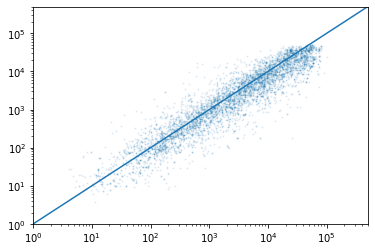

In [6]:
plt.scatter(true_mut_times, ancient_mut_times, s=1, alpha=0.1)
plt.xlim(1, 5e5)
plt.ylim(1, 5e5)
plt.yscale("log")
plt.xscale("log")
plt.plot(plt.xlim(), plt.ylim())